# 02 - Model Preprocessing

This notebook is used to extend audio measurement data with location based context 
such that the resulting gdf can be used to train a regression model to predict
measured noise levels.

The first code cell can be edited to define file locations, and which areas should be analyzed. 

In [1]:
dBA_nodes_input_path = '..\\output\\final_audio_raster_nodes.GEOJSON'
area_of_interest = 'Utrecht, Netherlands'
sub_areas = {#sub_area: (bbox in EPSG4326)
             'Lunetten': (52.057135,52.068401,5.125294,5.143876),
             'Science Park': (52.079691,52.091478,5.160871,5.188251),
             'Overvecht': (52.122212,52.132171,5.078688,5.096025)}
data_nodes_output_path = '..\\output\\final_data_nodes.GEOJSON'

height_tile_input_file = '..\\data\\height_tile_index.fgb'

In [2]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
pd.options.mode.copy_on_write = True
# raster geo data libs
import rioxarray as rxr
# audio libs
import soundfile as sf
import waveform_analysis
# OLS
from sklearn import linear_model
import statsmodels.formula.api as smf

import mgwr
import osmnx
osmnx.settings.default_crs = "EPSG:4326"
osmnx_crs = "EPSG:4326"
import requests
import gzip
import shutil
from pathlib import Path
import json
pd.set_option('display.max_columns', 500)
import shapely
# script file, not a module 

import utils

## Importing audio data & Setting up parameters

In [3]:
gdf = gpd.read_file(dBA_nodes_input_path, engine='pyogrio', use_arrow=True) # contains 1.5 million points. may take a minute

## Combining with OSM street data

In [4]:
def create_area_gdf(sub_area_name, sub_area_bbox, audio_gdf):
    # create a gdf containing all roads in relevant area
    car_road_types = ['highway', 'trunk', 'primary', 'secondary', 'tertiary', 'unclassified', 'residential', 'living_street', 'busway', 'service']
    road_filter = f'["highway"~"{'|'.join(car_road_types)}"]'
    osm_graph = osmnx.graph_from_bbox(bbox=sub_area_bbox, custom_filter=road_filter)
    _, road_gdf = osmnx.graph_to_gdfs(osm_graph)
    road_gdf = road_gdf[road_gdf['maxspeed'].notna()]
    
    # Sanitising road gdf: filter down to relevant columns
    road_gdf = road_gdf[[c for c in ['geometry', 'maxspeed', 'highway', 'bridge', 'junction'] if c in road_gdf.columns]]
    # Sanitising road gdf: fix typing maxspeed
    road_gdf['maxspeed'] = road_gdf['maxspeed'].apply(lambda x: max(x) if type(x) == list else x)
    road_gdf['maxspeed'] = pd.to_numeric(road_gdf['maxspeed'])
    # Sanitising road gdf: encode boolean columns
    for boolean_col in ('junction', 'bridge'):
        if boolean_col in road_gdf.columns:
            road_gdf[boolean_col] = road_gdf[boolean_col].apply(lambda x: isinstance(x, str))
        else:
            road_gdf[boolean_col] = False
    # Sanitising road gdf: dummy encode highway to road_types (rt_name) columns
    road_gdf['highway'] = road_gdf['highway'].apply(lambda x: x if type(x) == list else [x])
    for rt in car_road_types:
        road_gdf[f'rt_{rt}'] = road_gdf['highway'].apply(lambda l: rt in l)
    del road_gdf['highway']

    # For each audio node, attach information of the road it is on (ie within 10m of). 
    # Retain only nodes to which information has been attached.
    road_gdf = road_gdf.to_crs(gdf.crs)
    road_dba_gdf = audio_gdf.sjoin_nearest(road_gdf, max_distance=10).drop_duplicates()
    # Remove index columns
    for col in road_dba_gdf.columns:
        if 'index_' in col: del road_dba_gdf[col]
    # Finally attach column containing sub area name
    road_dba_gdf['sub_area'] = sub_area_name
    
    return road_dba_gdf

sub_area_gdfs = {area: create_area_gdf(area, bbox, gdf) for area, bbox in sub_areas.items()}

    

## Adding Location Distances

In [5]:
def expand_gdf_dist_to_train(gdf):
    """
    info here
    Uses notebook area_of_interest as sub area bbox may not contain the nearest railway.
    """
    g = osmnx.graph_from_place(area_of_interest, custom_filter='["railway"]')
    train_geoms = osmnx.graph_to_gdfs(g)[1].to_crs(gdf.crs).reset_index()['geometry']
    gdf['dist_to_train'] = train_geoms.sindex.nearest(
        gdf['geometry'], return_all=False, return_distance=True)[1] # distance index
    return gdf

sub_area_gdfs = {area: expand_gdf_dist_to_train(sub_area_gdfs[area]) for area, bbox in sub_areas.items()}

In [6]:
# retrieving recreation amenity features
def expand_gdf_dist_to_recreation(gdf):
    minx, miny, maxx, maxy = gdf.to_crs(osmnx_crs).total_bounds
    x_margin, y_margin = (maxx-minx)*0.5, (maxy-miny)*0.5
    bbox = (maxy+y_margin, miny-y_margin, maxx+x_margin, minx-x_margin)#north, south, east, west
    
    amenity_gdf = osmnx.features_from_bbox(bbox=bbox, tags={'amenity': [
                'bar','biergarten','cafe','fast_food','food_court',
                'ice_cream', 'pub', 'restaurant',
                'arts_centre', 'brothel', 'casino', 'cinema', 'community_centre', 
                'conference_centre', 'events_venue', 'exhibition_centre', 
                'gambling', 'love_hotel', 'music_venue', 'nightclub', 'planetarium', 
                'social_centre', 'stage', 'stripclub', 'studio', 'theatre']}
    ) 
    
    amenity_gdf = amenity_gdf.to_crs(gdf.crs)
    gdf['dist_to_recreation'] = amenity_gdf['geometry'].sindex.nearest(
        gdf['geometry'], return_all=False, return_distance=True)[1] # distance index
    return gdf

sub_area_gdfs = {area: expand_gdf_dist_to_recreation(gdf) for area, gdf in sub_area_gdfs.items()}


In [7]:
def expand_gdf_with_landuse(gdf):
    minx, miny, maxx, maxy = gdf.to_crs(osmnx_crs).total_bounds
    x_margin, y_margin = (maxx-minx)*0.5, (maxy-miny)*0.5
    bbox = (maxy+y_margin, miny-y_margin, maxx+x_margin, minx-x_margin)#north, south, east, west
    
    landuse = osmnx.features_from_bbox(bbox=bbox, tags={'landuse': True})
    landuse = landuse.to_crs(gdf.crs)
    
    gdf['landuse_is_residential'] = [dist < 10 for dist in 
        landuse[landuse['landuse'].isin(['residential'])]['geometry'].sindex.nearest(
        gdf['geometry'], return_all=False, return_distance=True)[1]]
    gdf['landuse_is_commercial'] = [dist < 10 for dist in 
        landuse[landuse['landuse'].isin(['commercial', 'retail'])]['geometry'].sindex.nearest(
        gdf['geometry'], return_all=False, return_distance=True)[1]]
    gdf['landuse_is_industrial'] = [dist < 10 for dist in 
        landuse[landuse['landuse'].isin(['industrial'])]['geometry'].sindex.nearest(
        gdf['geometry'], return_all=False, return_distance=True)[1]]
    return gdf

sub_area_gdfs = {area: expand_gdf_with_landuse(gdf) for area, gdf in sub_area_gdfs.items()}


In [8]:
sub_area_gdfs['Lunetten']

,y,x,dBA_rivm,no_observations,speed,speed_slt20,dBA_raw,dBA_raw_slt20,dBA_noise_red,dBA_noise_red_slt20,dBA_reg_adj,dBA_reg_adj_slt20,dBA_dual_red,dBA_dual_red_slt20,geometry,maxspeed,bridge,junction,rt_highway,rt_trunk,rt_primary,rt_secondary,rt_tertiary,rt_unclassified,rt_residential,rt_living_street,rt_busway,rt_service,sub_area,dist_to_train,dist_to_recreation,landuse_is_residential,landuse_is_commercial,landuse_is_industrial
1075453,453375.0,137375.0,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (137375.000 453375.000),30,False,False,False,False,False,False,False,False,True,False,False,False,Lunetten,639.139240,242.012427,True,False,False
1075453,453375.0,137375.0,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (137375.000 453375.000),30,False,False,False,False,False,False,False,False,True,False,False,False,Lunetten,639.139240,242.012427,True,False,False
1075454,453375.0,137385.0,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (137385.000 453375.000),30,False,False,False,False,False,False,False,False,True,False,False,False,Lunetten,632.082784,232.174044,True,False,False
1075454,453375.0,137385.0,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (137385.000 453375.000),30,False,False,False,False,False,False,False,False,True,False,False,False,Lunetten,632.082784,232.174044,True,False,False
1075455,453375.0,137395.0,64,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (137395.000 453375.000),50,False,False,False,False,False,False,False,False,True,False,False,False,Lunetten,625.026328,222.350082,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239130,452125.0,137895.0,53,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (137895.000 452125.000),30,False,False,False,False,False,False,False,False,True,False,False,True,Lunetten,1392.166014,26.740230,True,False,False
1240438,452115.0,137885.0,53,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (137885.000 452115.000),30,False,False,False,False,False,False,False,False,True,False,False,True,Lunetten,1405.407438,23.879037,True,False,False
1240438,452115.0,137885.0,53,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (137885.000 452115.000),30,False,False,False,False,False,False,False,False,True,False,False,True,Lunetten,1405.407438,23.879037,True,False,False
1240439,452115.0,137895.0,53,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (137895.000 452115.000),30,False,False,False,False,False,False,False,False,True,False,False,True,Lunetten,1401.269903,17.494343,True,False,False


## Adding urban height parameter

In [9]:
# Downloading relevant height tiles and combining into singular gdf

def download_and_extract_gpkg(url, output_path):
    """
    Utility for processing gpkg files.
    """
    output_path = Path(output_path)
    # Download the file
    response = requests.get(url, stream=True)
    compressed_file_path = output_path.with_suffix('.gz')

    # Save the gzipped file
    with open(compressed_file_path, 'wb') as f:
        f.write(response.content)

    # Decompress the file
    with gzip.open(compressed_file_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Clean up
    compressed_file_path.unlink()

def create_gpkg_height_gdf(height_tiles):
    """
    Utility to extract height data from 3dbag gpkg files.
    """
    height_gdf = None
    for url in height_tiles['gpkg_download']:
        # for each height tile, download & cache it (or load from cache)
        file_name = url.split('/')[-1][:-3]
        file_location= f'..\\data\\height_squares\\{file_name}'
        if not os.path.isfile(file_location):
            download_and_extract_gpkg(url, file_location)
        gdf = gpd.read_file(file_location)
        # combine resulting gdf's
        if not isinstance(gdf, pd.DataFrame): height_gdf = gdf; continue
        height_gdf = pd.concat((height_gdf, gdf))
    return height_gdf

def create_cityjson_height_gdf(height_tiles):
    """
    Utility to extract meta data from 3dbag cj files.
    """
    height_gdf = None
    for url in height_tiles['cj_download']:
        # for each height tile, download & cache it (or load from cache)
        file_name = url.split('/')[-1][:-3]
        file_location= f'..\\data\\height_squares\\{file_name}'
        if not os.path.isfile(file_location):
            download_and_extract_gpkg(url, file_location)
        with open(file_location, 'r', encoding='utf-8') as f:
            json_data = json.load(f)

        # extract building height and id's from json data
        h_70p = [json_data['CityObjects'][building_obj]['attributes']['b3_h_dak_70p'] 
            for building_obj in json_data['CityObjects'].keys()
            if 'b3_h_dak_min' in json_data['CityObjects'][building_obj]['attributes'].keys()]
        h_id = [building_obj
                for building_obj in json_data['CityObjects'].keys()
                if 'b3_h_dak_min' in json_data['CityObjects'][building_obj]['attributes'].keys()]

        # combining extracted data into singular df
        df = pd.DataFrame({'identificatie': h_id, 'height_70p': h_70p})
        if not isinstance(df, pd.DataFrame): height_gdf = df; continue
        height_gdf = pd.concat((height_gdf, df))

    return height_gdf

def get_building_for_road(road_gdf, building_heights, buffer_radius=25, height_col='height_70p'):
    road_points = road_gdf['geometry'].buffer(buffer_radius) 
    return [building_heights[building_heights['geometry'].intersects(rp)][height_col].max() 
            for rp in road_points]

def expand_gdf_dist_with_building_height(gdf, height_tile_input_file):
    """Functio"""
    print(f'Started collecting building heights for {gdf['sub_area'].unique()}...')
    # extract relevant height tiles to download from 3dbag project
    bbox = gdf['geometry'].total_bounds
    height_tiles = gpd.read_file(height_tile_input_file, engine='pyogrio', use_arrow=True)
    height_tiles = height_tiles[height_tiles['geometry'].intersects(shapely.box(*bbox))]
    # retrieve relevant data from gpkg and cityjson formatted files (each contains unique information)
    gpkg_heights = create_gpkg_height_gdf(height_tiles)
    print('finished downloading gpkg files...', end=' ')
    cj_heights = create_cityjson_height_gdf(height_tiles)
    print('finished downloading cityjson files...')
    # combine data into singular gdf
    height_gdf = gpkg_heights.merge(cj_heights, on='identificatie', how='left')
    # extract building height information into gdf
    gdf['building_height'] = get_building_for_road(gdf, height_gdf)
    gdf['building_height'] = gdf['building_height'].fillna(0)
    print('Done :)')
    return gdf

sub_area_gdfs = {area: expand_gdf_dist_with_building_height(gdf, height_tile_input_file) for area, gdf in sub_area_gdfs.items()}


Started collecting building heights for ['Lunetten']...
finished downloading gpkg files... finished downloading cityjson files...
Done :)
Started collecting building heights for ['Science Park']...
finished downloading gpkg files... finished downloading cityjson files...
Done :)
Started collecting building heights for ['Overvecht']...
finished downloading gpkg files... finished downloading cityjson files...
Done :)


## Saving

In [10]:
# gdf = pd.concat(sub_area_gdfs.values())
# gdf.to_file(data_nodes_output_path)

## Experiments

In [11]:
gdf.plot(column='dBA_rivm', alpha=0.0025)

<Axes: >

Error in callback <function flush_figures at 0x0000026B815214E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

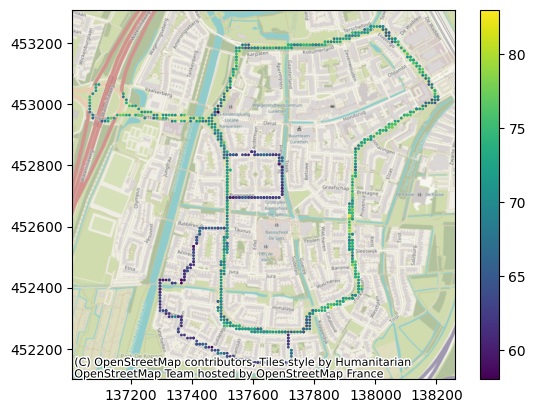

In [ ]:
ax = gdf[gdf['sub_area'] == 'Lunetten'].plot(column='dBA_reg_adj', markersize=1, legend=True)
cx.add_basemap(ax, crs=gdf.crs)

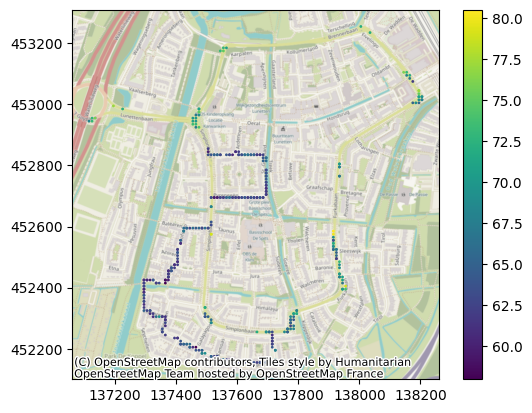

In [ ]:
ax = gdf[gdf['sub_area'] == 'Lunetten'].plot(column='dBA_reg_adj_slt20', markersize=1, legend=True)
cx.add_basemap(ax, crs=gdf.crs)

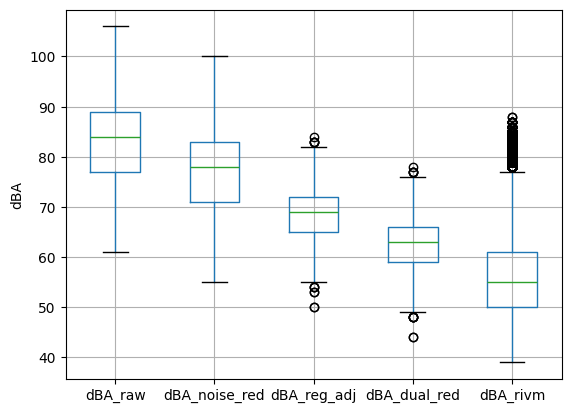

In [18]:
gdf.boxplot(column=['dBA_raw', 'dBA_noise_red', 'dBA_reg_adj', 'dBA_dual_red', 'dBA_rivm'], ylabel='dBA')
plt.savefig('adjAudioBox.png', dpi=1600)

In [ ]:
road_dba_gdf

,x,y,geometry,dBA_raw,dBA_reg,dBA_rivm,maxspeed,bridge,junction,rt_highway,rt_trunk,rt_primary,rt_secondary,rt_tertiary,rt_unclassified,rt_residential,rt_living_street,rt_busway,rt_service,dist_to_train,dist_to_recreation,landuse_is_residential,landuse_is_commercial,landuse_is_industrial,building_height
158858,134425.0,460375.0,POINT (134425.000 460375.000),NaN,NaN,62,50,False,False,False,False,False,False,True,False,False,False,False,False,2138.571084,554.012717,False,False,True,0.00
158858,134425.0,460375.0,POINT (134425.000 460375.000),NaN,NaN,62,50,False,False,False,False,False,False,True,False,False,False,False,False,2138.571084,554.012717,False,False,True,0.00
158859,134435.0,460375.0,POINT (134435.000 460375.000),NaN,NaN,64,50,False,False,False,False,False,False,True,False,False,False,False,False,2145.470344,545.475849,False,False,True,8.94
158859,134435.0,460375.0,POINT (134435.000 460375.000),NaN,NaN,64,50,False,False,False,False,False,False,True,False,False,False,False,False,2145.470344,545.475849,False,False,True,8.94
158860,134445.0,460375.0,POINT (134445.000 460375.000),NaN,NaN,63,50,False,False,False,False,False,False,True,False,False,False,False,False,2152.349702,536.989491,False,False,True,8.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289804,134885.0,459375.0,POINT (134885.000 459375.000),NaN,NaN,51,30,False,False,False,False,False,False,False,False,True,False,False,False,1726.504999,140.541911,True,False,False,9.74
289805,134895.0,459375.0,POINT (134895.000 459375.000),NaN,NaN,52,30,False,False,False,False,False,False,False,False,True,False,False,False,1733.360833,134.022139,True,False,False,9.74
289805,134895.0,459375.0,POINT (134895.000 459375.000),NaN,NaN,52,30,False,False,False,False,False,False,False,False,True,False,False,False,1733.360833,134.022139,True,False,False,9.74
289805,134895.0,459375.0,POINT (134895.000 459375.000),NaN,NaN,52,30,False,False,False,False,False,False,False,False,True,False,False,False,1733.360833,134.022139,True,False,False,9.74


In [ ]:
sub_areas

{'Lunetten': (52.057135, 52.068401, 5.125294, 5.143876),
 'Science Park': (52.079691, 52.091478, 5.160871, 5.188251),
 'Overvecht': (52.122212, 52.132171, 5.078688, 5.096025)}

In [ ]:
sub_area_boxes = {a: shapely.box(xmin, ymin, xmax, ymax) for a, (ymin, ymax, xmin, xmax) in sub_areas.items()}
sub_area_boxes
sub_area_gdf = gpd.GeoDataFrame(data={'area': sub_areas.keys()}, geometry=list(sub_area_boxes.values()), crs=)
sub_area_gdf

,area,geometry
0,Lunetten,"POLYGON ((5.14388 52.05714, 5.14388 52.06840, ..."
1,Science Park,"POLYGON ((5.18825 52.07969, 5.18825 52.09148, ..."
2,Overvecht,"POLYGON ((5.09603 52.12221, 5.09603 52.13217, ..."


In [ ]:
import osmnx

In [ ]:

admin_boundaries = osmnx.features_from_place('Utrecht, the Netherlands', tags={'boundary': 'administrative'})

u_boundary_gdf = gpd.GeoDataFrame(data={'area': ['Utrecht']}, geometry=admin_boundaries[admin_boundaries['wikidata'] == 'Q39297398']['geometry'].values, crs='EPSG:4326')

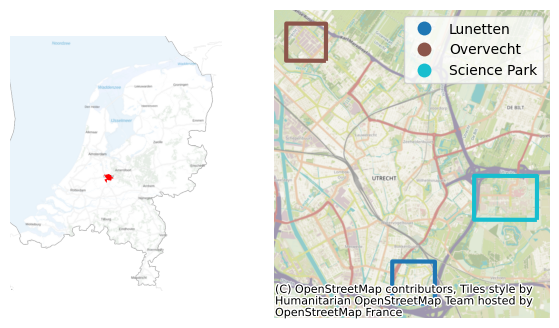

In [ ]:
sub_area_gdf = sub_area_gdf.to_crs('EPSG:28992')

fig, (axnl, ax) = plt.subplots(1,2, width_ratios=[3,4], figsize=(7,4))
sub_area_gdf.plot(ax=ax, column='area', legend=True, facecolor="none", edgecolor=None, linewidth=3)
cx.add_basemap(ax=ax, crs=sub_area_gdf.crs)
ax.set_axis_off()

u_boundary_gdf.plot(ax=axnl)
cx.add_basemap(ax=axnl, crs=u_boundary_gdf.crs, attribution="hi",  attribution_size=1)


u_boundary_gdf.to_crs('EPSG:28992').plot(ax=axnl, color='red', markersize=100)

# Set the x and y limits to focus on the Netherlands
axnl.set_xlim([0, 290000])
axnl.set_ylim([300000, 650000])
axnl.set_axis_off()


# Add the basemap from contextily
cx.add_basemap(axnl, crs='EPSG:28992', source=cx.providers.nlmaps.grijs, attribution=False, attribution_size=0.3)



<Axes: title={'center': 'Nederland'}, xlabel='X', ylabel='Y'>

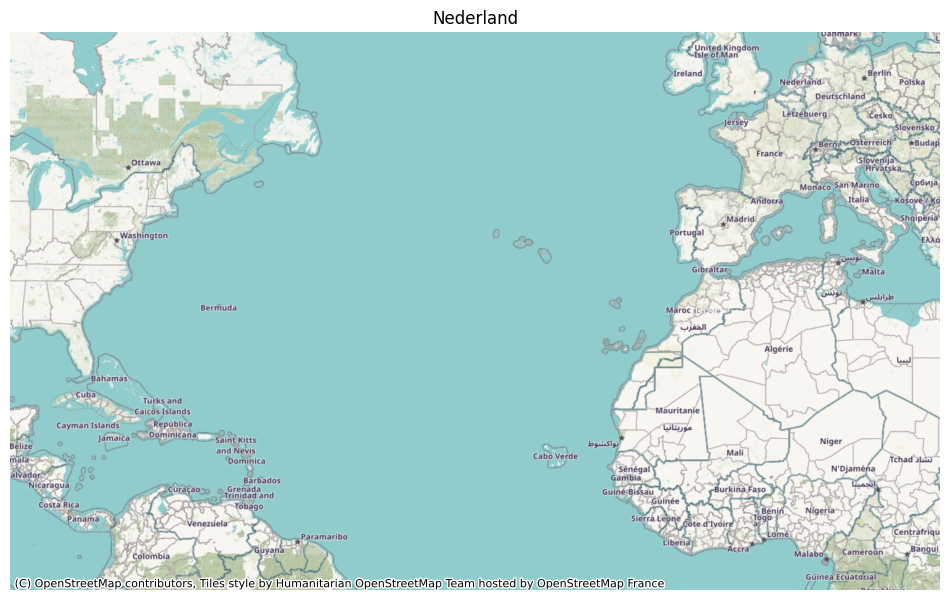

In [ ]:
cx.Place('netherlands').plot()

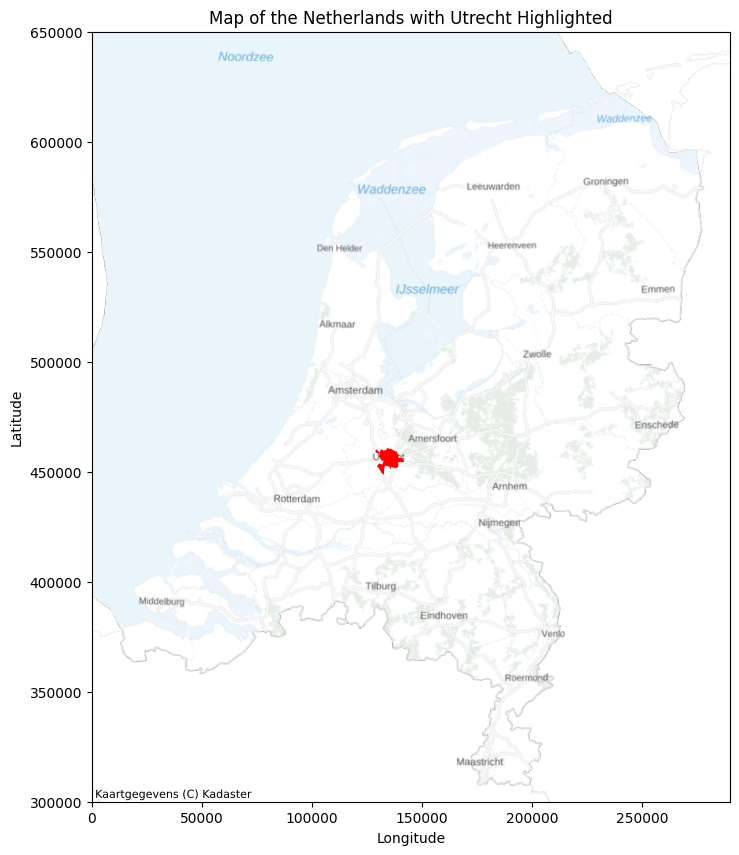

In [ ]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Utrecht point
u_boundary_gdf.to_crs('EPSG:28992').plot(ax=ax, color='red', markersize=100)

# Set the x and y limits to focus on the Netherlands
ax.set_xlim([0, 290000])
ax.set_ylim([300000, 650000])

# Add the basemap from contextily
cx.add_basemap(ax, crs='EPSG:28992', source=cx.providers.nlmaps.grijs)

# Add labels and title
ax.set_title('Map of the Netherlands with Utrecht Highlighted')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()
